<a href="https://colab.research.google.com/github/tiffanymoran/AlbumGAN/blob/main/AlbumGAN_StyleGAN3_%2B_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generates album art covers using NVIDIA StyleGAN3 with CLIP guidance.

Based off of nshepperd's (https://twitter.com/nshepperd1, https://github.com/nshepperd, https://colab.research.google.com/drive/1eYlenR1GHPZXt-YuvXabzO9wfh9CWY36#scrollTo=QXoRP4SHzJ6i) StyleGAN3 + CLIP implementation.

In [ ]:
#@markdown #**Check GPU** 

#@markdown ---

#@markdown V100 = Excellent (*Available only for Colab Pro users*)

#@markdown P100 = Very Good

#@markdown T4 = Good (*preferred*)

#@markdown K80 = Meh

#@markdown P4 = (*Not Recommended*) 

#@markdown ---

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a70456a4-344d-3a5e-b917-ade849abd791)


In [ ]:
#@markdown #**Install libraries** 

#@markdown ---

!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja

import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan3')

import io
import os, time
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

if torch.cuda.get_device_capability(device) == (8,0):
    print('Disabling CUDNN for A100 gpu', file=sys.stderr)
    torch.backends.cudnn.enabled = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:14:39tcmalloc: large alloc 1147494400 bytes == 0x3903e000 @  0x7f4ff8568615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:21tcmalloc: large alloc 1434370048 bytes == 0x7d694000 @  0x7f4ff8568615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [1]:
#downloads the trained StyleGAN3 and CLIP models
!gdown --id 1roRl37CawcygPAdFJqiXpcwVwZ9U0nGN 
!gdown --id 10uApGdM2Ob6iGEwkOz16TraT4M0TB57k

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1roRl37CawcygPAdFJqiXpcwVwZ9U0nGN
To: /content/albumgan-clip-model.pt
100% 1.56G/1.56G [00:09<00:00, 171MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10uApGdM2Ob6iGEwkOz16TraT4M0TB57k
To: /content/albumgan-stylegan3-model.pkl
100% 364M/364M [00:01<00:00, 193MB/s]


In [ ]:
#@markdown #**Optional:** Save images to your Google Drive
# @markdown Run this cell if you want to store the results inside Google Drive, which is faster.

# @markdown **Important**: you must have a folder named *samples* inside your drive, otherwise images will save directly to your computer.

#@markdown ---

# Uncomment to copy generated images to drive, faster than downloading directly from colab in my experience.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@markdown #**Define necessary functions**

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        !wget -c '{url_or_path}'
        return basename

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

In [ ]:
#@markdown #**Load custom trained CLIP model**

class CLIP(object):
  def __init__(self):
    model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
    checkpoint = torch.load("/content/albumgan-clip-model.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    self.model = model.eval()
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

In [ ]:
#@markdown #**Load custom StyleGAN3 model**

#base_url = "/content/drive/MyDrive/WIP/stylegan3/"
#model_name = "final-network-snapshot-000080.pkl"
#model_name = "final-network-snapshot-000080.pkl"
network_url = "/content/albumgan-stylegan3-model.pkl"

with open(network_url, 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

# # Fix the coordinate grid to w_avg
# shift = G.synthesis.input.affine(G.mapping.w_avg.unsqueeze(0))
# G.synthesis.input.affine.bias.data.add_(shift.squeeze(0))
# G.synthesis.input.affine.weight.data.zero_()

# # Arbitrary coordinate grid (dubious idea)
# with torch.no_grad():
#   grid = G.synthesis.input(G.mapping.w_avg.unsqueeze(0))
#   def const(x):
#     def f(w):
#       n = w.shape[0]
#       return x.broadcast_to([n, *x.shape[1:]])
#     return f
#   G.synthesis.input.forward = const(grid)
# grid.requires_grad_()

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

In [ ]:
#@markdown #**Parameters**

#@markdown `texts`: Enter song lyrics here to guide the image generation. 

lyrics = "Somebody you never met But loving him was red Oh, red Burning red"#@param {type:"string"}

target = clip_model.embed_text(lyrics)
steps = 300
seed = np.random.randint(0, 9e9)

tensor([0.8970, 0.9296, 0.9160, 0.9197, 0.9186, 0.9004, 0.9205, 0.9266],
       device='cuda:0')
torch.Size([8]) torch.Size([8, 16, 512])


  0%|          | 0/300 [00:00<?, ?it/s]

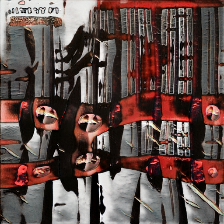

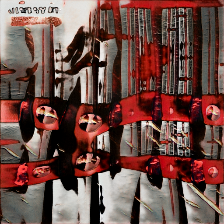

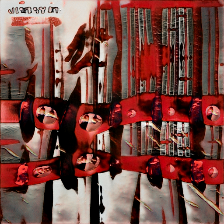

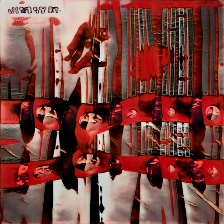

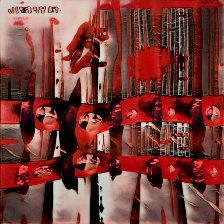

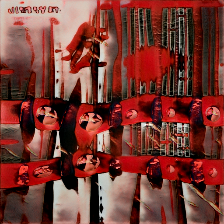

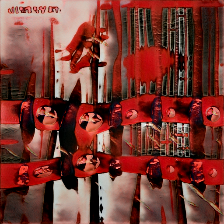

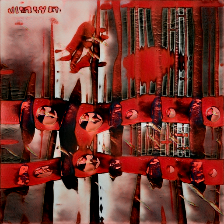

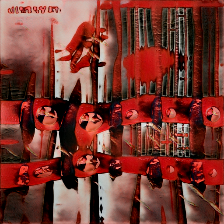

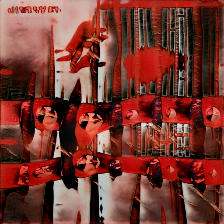

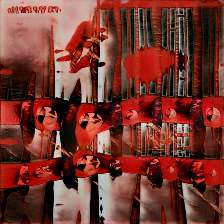

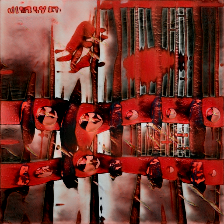

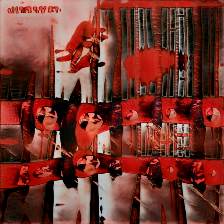

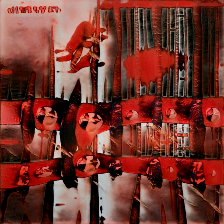

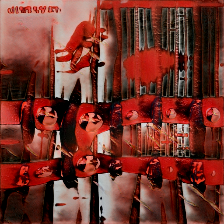

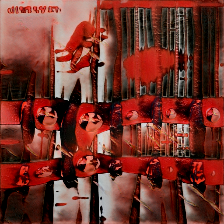

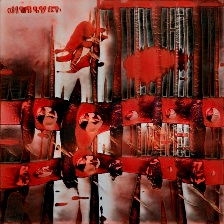

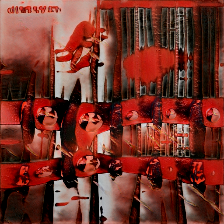

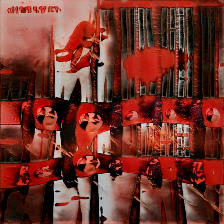

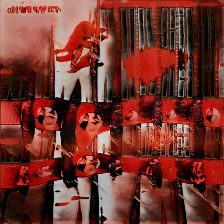

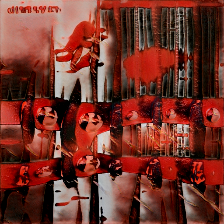

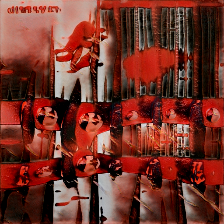

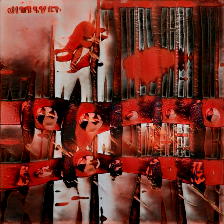

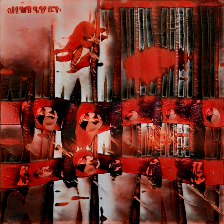

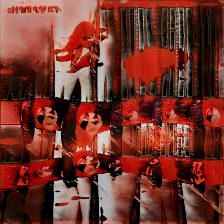

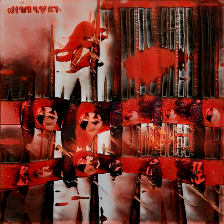

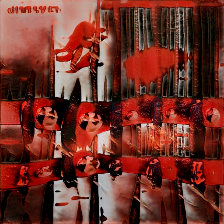

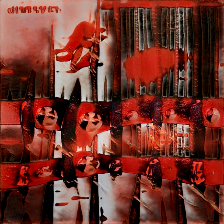

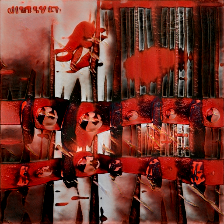

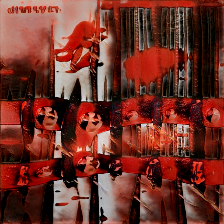

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown #**Run the model**

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

def run():
  torch.manual_seed(seed)
  timestring = time.strftime('%Y%m%d%H%M%S')

  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(8):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      embeds = embed_image(images.add(1).div(2))
      loss = spherical_dist_loss(embeds, target).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    print(losses)
    print(losses.shape, qs.shape)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = spherical_dist_loss(embed, target).mean()
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')
  
  # Save images as a tar archive
  !tar cf samples/{timestring}.tar samples/{timestring}
  if os.path.isdir('drive/MyDrive/samples'):
    shutil.copyfile(f'samples/{timestring}.tar', f'drive/MyDrive/samples/{timestring}.tar')
  else:
    files.download(f'samples/{timestring}.tar')

try:
  run()
except KeyboardInterrupt:
  pass

In [ ]:
#@title Licensed under the MIT License { display-mode: "form" }

# Copyright (c) 2021 nshepperd; Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.